# Exploration08_ human image segmentation
>date: 19 oct 2021<br>
author : benjamin<br>
e-mail : naroo135@gmail.com

## overview
  사람은 시각 정보에 대해서 모든 내용들을 한꺼번에 인지하지 못한다. 사람이 보고 있는 대상들에 대해서 주의를 끄는 부분에 대해서 선명하게 인지한다. 예를 들면 농구경기를 볼 때 사람들은 선수 개개인을 실시간으로 모두 의식하여 보지 않는다. 주로 농구공의 움직임, 농구공을 소유하고 있는 선수, 각 팀들의 포메이션 등에 대해서 주의를 기울여 의식한다. 주의를 기울이지 않는 그 외의 시각 정보들에 대해선 의식영역의 밖으로 취급한다. 이러한 주의의 한계에 대해서 계획적이지 않은 촬영 이미지들은 중요한 피사체(대상)에 대해서 주의를 기울이는데 적합하지 않을 수 있다. 인물을 촬영하는데 주변의 난잡한 이미지들은 인물에 대해서 주의를 기울이는데 방해요소로 작용하며 인물 자체에 대해서 주의를 충분히 이끌지 못한다. 따라서 이번 exploraration은 인물과 같은 target image외에 다른 이미지 정보들의 영향력을 감소시키는 작업 처리를 해볼 예정이다.


## concept of focus
  LMS에 소개된 내용과 같이 인물 사진을 촬영 시 2개의 렌즈가 각기 다른 동작들을 수행하여 하나의 이미지로 합성하는 과정으로 인물이 부각할 수 있도록 이미지 처리 방식을 
  
  
  
## design flow



## required module
  `DeepLabModel` class<br>
  `tarfile` module<br>
  `pretrained weight`



In [22]:
from google.colab import files
file_upload = files.upload()

Saving yhg.jpg to yhg.jpg


In [28]:
for fn in file_upload.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(file_upload[fn])))

User uploaded file "yhg.jpg" with length 463759 bytes


### Work(1) : img loading

배우 '양혜지'이미지를 불러와서 실험해 볼 예정이다.

In [7]:
import cv2
import numpy as np
import os
import tarfile
import urllib
import pandas as pd

from matplotlib import pyplot as plt
import tensorflow as tf

In [29]:
#img_path = file_dir + '/yhg.jpg'
print(img_path)
img_orig = cv2.imread('yhg.jpg')
print(img_orig.shape)

/content/drive/Mydrive/Colab/data/yhg.jpg
(960, 640, 3)


### Work(2) : definition of deeplab model class

* what is deeplab?

In [30]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

### work(3) : getting of pretrained weight from google

In [31]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/EXP08_human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /root/aiffel/EXP08_human_segmentation/models
model loaded successfully!


### work(4) : img resize

In [32]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(960, 640, 3) (513, 342, 3) 15


### work(5) : extraction of 'person'

In [33]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

Text(0.5, 1.0, 'extracted img')

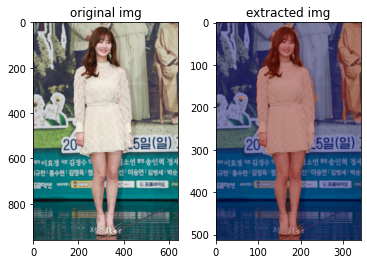

In [34]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

fig = plt.figure()
nrows = 1
ncols = 2

axe1 = fig.add_subplot(nrows,ncols,1)
axe1.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
axe1.set_title('original img')

axe2 = fig.add_subplot(nrows,ncols,2)
axe2.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
axe2.set_title('extracted img')

### work(6) : img scale up with interpoloaration

  처리된 이미지를 다시 원래 사이즈로 돌리기 위해선 픽셀 수를 증가시켜야 한다. 처리된 이미지의 픽셀 수를 몇 배 증가시킨다고 할 때 빈 공간의 픽셀이 점유하게 된다. 이 빈 공간이 아무런 픽셀 값이 주어지지 않을 때 모자이크와 같은 부자연스러운 이미지로 확대될 것이다. 이러한 문제에 대해서 빈 픽셀에 대해 적절한 픽셀값을 채워야 자연스러운 이미지로 확대할 수 있다. 자연스러운 이미지로 확대하기 위해선 보간(interpoloaration)의 기법들을 이용할 수 있다. 이 exploraration에서는 `cv2.INTER_LINEAR`의 interpoloartion을 이용하였다.
  
  

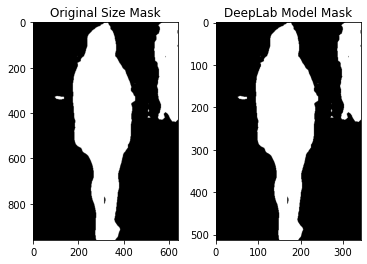

In [35]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

### work(7) : img blurring and combining of person img and blurred background

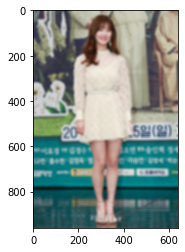

In [36]:
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

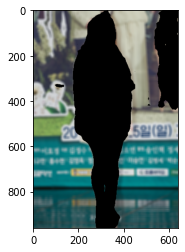

In [37]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

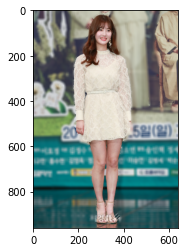

In [38]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()